In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB

# Data Preparation

In [3]:
data = pd.read_csv('data2020.student.csv')
data = data.loc[0:999,:]

In [4]:
to_rem = []
to_cat = []
num_cols = []
cat_cols = []

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1000 non-null   int64  
 1   Class   1000 non-null   float64
 2   C1      995 non-null    float64
 3   C2      996 non-null    float64
 4   C3      1000 non-null   object 
 5   C4      1000 non-null   int64  
 6   C5      1000 non-null   object 
 7   C6      1000 non-null   int64  
 8   C7      1000 non-null   object 
 9   C8      1000 non-null   int64  
 10  C9      1000 non-null   int64  
 11  C10     1000 non-null   object 
 12  C11     1000 non-null   object 
 13  C12     1000 non-null   object 
 14  C13     1000 non-null   int64  
 15  C14     995 non-null    object 
 16  C15     1000 non-null   int64  
 17  C16     1000 non-null   object 
 18  C17     1000 non-null   object 
 19  C18     1000 non-null   object 
 20  C19     996 non-null    object 
 21  C20     1000 non-null   int64  
 22  C

## Removing attributes with no information.

In [6]:
for col in data:
    if len(data[col].value_counts()) == 1:
        print(col)
        to_rem.append(col)
        data = data.drop(col,axis=1)

C15
C17
C21
C22


## Determining object attributes that should be categorical

In [7]:
for col in data.select_dtypes(include=object):
    data[col] = data[col].astype('category')
    to_cat.append(col)

## Determining numeric attributes that should be categrocial

In [8]:
for col in data.select_dtypes(include=np.number):
    if data[col].nunique() < 5:
        data[col] = data[col].astype('category')
        to_cat.append(col)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      1000 non-null   int64   
 1   Class   1000 non-null   category
 2   C1      995 non-null    float64 
 3   C2      996 non-null    category
 4   C3      1000 non-null   category
 5   C4      1000 non-null   category
 6   C5      1000 non-null   category
 7   C6      1000 non-null   int64   
 8   C7      1000 non-null   category
 9   C8      1000 non-null   int64   
 10  C9      1000 non-null   category
 11  C10     1000 non-null   category
 12  C11     1000 non-null   category
 13  C12     1000 non-null   category
 14  C13     1000 non-null   int64   
 15  C14     995 non-null    category
 16  C16     1000 non-null   category
 17  C18     1000 non-null   category
 18  C19     996 non-null    category
 19  C20     1000 non-null   int64   
 20  C23     1000 non-null   category
 21  C24     1000 no

## Setting major missing entries to dummy variables

In [10]:
for col in data:
    if (data[col].isnull().sum() / data.shape[0]) > 0.05:
        if pd.api.types.is_categorical(data[col]):
            data[col] = data[col].cat.add_categories('Unknown')
            data[col] = data[col].fillna('Unknown')
        elif pd.api.types.is_number(data[col]):
            data[col].fillna(0)

## Dropping small numbers of missing entries

In [11]:
data = data.dropna()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982 entries, 0 to 999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      982 non-null    int64   
 1   Class   982 non-null    category
 2   C1      982 non-null    float64 
 3   C2      982 non-null    category
 4   C3      982 non-null    category
 5   C4      982 non-null    category
 6   C5      982 non-null    category
 7   C6      982 non-null    int64   
 8   C7      982 non-null    category
 9   C8      982 non-null    int64   
 10  C9      982 non-null    category
 11  C10     982 non-null    category
 12  C11     982 non-null    category
 13  C12     982 non-null    category
 14  C13     982 non-null    int64   
 15  C14     982 non-null    category
 16  C16     982 non-null    category
 17  C18     982 non-null    category
 18  C19     982 non-null    category
 19  C20     982 non-null    int64   
 20  C23     982 non-null    category
 21  C24     982 non-

## Removing ID column 

In [13]:
data = data.drop('ID',1)

## Removing duplicate data

In [14]:
data = data.drop_duplicates()

## Determining linearly independent numeric columns

In [15]:
Q,R = np.linalg.qr(data.select_dtypes(include=np.number))
inds=[]
for i in range(0, len(R)):
    if abs(R[i,i]) > 1e-15:
        inds.append(i)
print('Columns: ' + str(data.select_dtypes(include=np.number).columns))
print('Independent Columns: ' + str(inds))
cols = data.select_dtypes(include=np.number).columns
for i in range(0,len(cols)):
    if i not in inds:     
        data = data.drop(cols[i],axis=1)


Columns: Index(['C1', 'C6', 'C8', 'C13', 'C20', 'C26', 'C30'], dtype='object')
Independent Columns: [0, 1, 2, 3, 4, 5, 6]


## Assigning columns to categorical or numeric

In [16]:
for col in data:
    if pd.api.types.is_numeric_dtype(data[col]):
        num_cols.append(col)
    elif col != 'Class':
        cat_cols.append(col)

## Plotting Pairs

In [17]:
#sbplot = sb.pairplot(data, hue = 'Class',diag_kws={'bw': 1})
#sbplot.savefig('exploratory.jpg')

## Performing hot encoding

In [18]:
dataEnc = OneHotEncoder().fit(data[cat_cols].astype(str))
data = data.reset_index(drop=True)

In [19]:
data = data.drop(cat_cols,axis=1).join(pd.DataFrame(dataEnc.transform(data[cat_cols].astype(str)).toarray()))

## Resampling to adjust for class imbalance

In [20]:
data['Class'].value_counts()

0.0    636
1.0    246
Name: Class, dtype: int64

In [21]:
data = data.loc[data['Class']==0,:].append(resample(data.loc[data['Class']==1,:], replace = True, n_samples = 636, random_state = 76))
data['Class'].value_counts()

1.0    636
0.0    636
Name: Class, dtype: int64

## Splitting test and training 


In [22]:
train_data, test_data = train_test_split(data,test_size = 0.15, stratify = data['Class'], random_state = 21)

## Standardising numeric training and test data

In [23]:
dataScaler = StandardScaler().fit(train_data[num_cols])

In [24]:
train_data[num_cols] = dataScaler.transform(train_data[num_cols])
test_data[num_cols] = dataScaler.transform(test_data[num_cols])

## Performing PCA on data

In [25]:
#Pairs plot prior to PCA

#tmp = num_cols.copy()
#tmp.append('Class')
#sbplot = sb.pairplot(train_data[tmp], hue = 'Class',diag_kws={'bw': 1})
#plt.suptitle('Data Prior to PCA Transformation',y=1.01)
#plt.savefig('Data Prior to PCA Transformation.jpg')

In [26]:
dataPCA = PCA().fit(train_data[num_cols])
print(num_cols)
print(dataPCA.explained_variance_ratio_)

['C1', 'C6', 'C8', 'C13', 'C20', 'C26', 'C30']
[4.65852663e-01 1.50979961e-01 1.48315083e-01 1.28567294e-01
 1.06284999e-01 3.91582241e-34 1.88053416e-34]


In [27]:
train_data[num_cols] = dataPCA.transform(train_data[num_cols])
test_data[num_cols] = dataPCA.transform(test_data[num_cols])

In [28]:
train_data[num_cols].cov()

,C1,C6,C8,C13,C20,C26,C30
C1,3.263988e+00,-5.263280e-17,9.868649e-18,-1.644775e-18,1.809252e-17,1.564436e-16,5.187894e-18
C6,-5.263280e-17,1.057838e+00,1.924387e-16,1.200686e-16,3.618505e-17,2.773115e-17,-2.195578e-17
C8,9.868649e-18,1.924387e-16,1.039167e+00,8.182755e-17,6.167906e-19,-3.878631e-17,-1.919959e-17
C13,-1.644775e-18,1.200686e-16,8.182755e-17,9.008044e-01,-3.947460e-17,-1.206249e-17,2.282887e-17
C20,1.809252e-17,3.618505e-17,6.167906e-19,-3.947460e-17,7.446839e-01,4.834295e-17,-7.919714e-17
C26,1.564436e-16,2.773115e-17,-3.878631e-17,-1.206249e-17,4.834295e-17,1.515387e-32,-5.042584e-33
C30,5.187894e-18,-2.195578e-17,-1.919959e-17,2.282887e-17,-7.919714e-17,-5.042584e-33,1.080915e-32


In [29]:
#Pairs plot post PCA

#sbplot = sb.pairplot(train_data[tmp], hue = 'Class',diag_kws={'bw': 1})
#plt.suptitle('Data Post PCA Transformation',y=1.01)
#plt.savefig('Data Post PCA Transformation.jpg')

## Using LOF to remove outliers

In [30]:
cLOF = LocalOutlierFactor(n_neighbors=6,metric='manhattan').fit_predict(train_data)
train_data = train_data.loc[cLOF==1,:]

## Performing cluster analysis

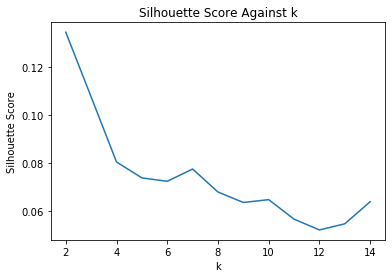

In [31]:
sil = []
ks = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,random_state=67).fit(train_data)
    sil.append(silhouette_score(train_data,kmeans.labels_,metric='manhattan'))
    ks.append(k)
plt.plot(ks,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.show()


In [32]:
#kmeans = KMeans(n_clusters=2,random_state=67).fit(train_data)

In [33]:
#train_data['Cluster'] = kmeans.predict(train_data)
#test_data['Cluster'] = kmeans.predict(test_data)

Given that the silhouette plot demonstrates no global optimum clustering is removed from model.

# Analysis

In [34]:
cv = StratifiedKFold(n_splits=10, random_state=296)

In [35]:
x_train = train_data.drop('Class',axis=1)
y_train = train_data['Class']
x_test = test_data.drop('Class',axis=1)
y_test = test_data['Class']

### Naive Bayes

In [36]:
cnb = GaussianNB().fit(x_train,y_train)

In [37]:
sacc = cross_val_score(cnb, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(cnb.predict(x_test) == y_test)/len(y_test)

print('Logistic Regression')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(cnb.predict(x_test), y_test))

Logistic Regression
Stratified Accuracy on Training Data: 0.5162087912087913
Actual Accuracy on Test Data        : 0.5497382198952879


              precision    recall  f1-score   support

         0.0       0.09      1.00      0.17         9
         1.0       1.00      0.53      0.69       182

    accuracy                           0.55       191
   macro avg       0.55      0.76      0.43       191
weighted avg       0.96      0.55      0.67       191



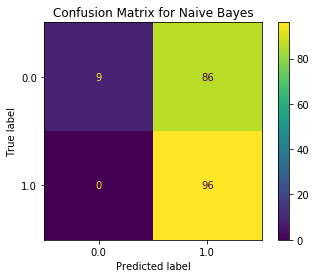

In [38]:
plot_confusion_matrix(cnb,x_test,y_test)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

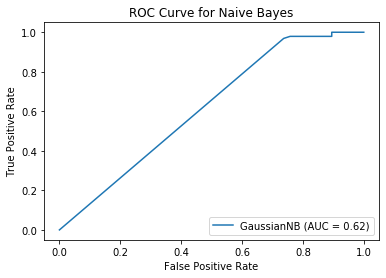

In [39]:
plot_roc_curve(cnb,x_test,y_test)
plt.title('ROC Curve for Naive Bayes')
plt.show()

### k-Nearest Neighbours Classifier

In [40]:
#Optimising model in region about default values
params = {
    'n_neighbors' : [i for i in range(5,10)],
    'leaf_size' : [i for i in range(25,35)]
}
knn = KNeighborsClassifier()
gd_sr = GridSearchCV(estimator=knn,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
knn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'leaf_size': 25, 'n_neighbors': 5}


In [41]:
sacc = cross_val_score(knn, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(knn.predict(x_test) == y_test)/len(y_test)

print('k-Nearest Neighbours')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(knn.predict(x_test), y_test))

k-Nearest Neighbours
Stratified Accuracy on Training Data: 0.7700274725274725
Actual Accuracy on Test Data        : 0.8429319371727748


              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84        95
         1.0       0.84      0.84      0.84        96

    accuracy                           0.84       191
   macro avg       0.84      0.84      0.84       191
weighted avg       0.84      0.84      0.84       191



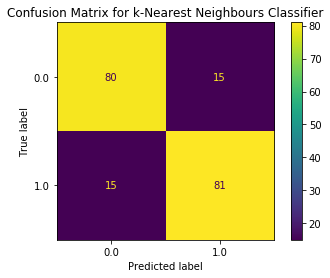

In [42]:
plot_confusion_matrix(knn,x_test,y_test)
plt.title('Confusion Matrix for k-Nearest Neighbours Classifier')
plt.show()

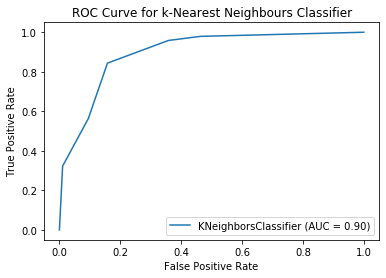

In [43]:
plot_roc_curve(knn,x_test,y_test)
plt.title('ROC Curve for k-Nearest Neighbours Classifier')
plt.show()

### Logistic Regression

In [44]:
#Optimising model in region about default values
params = {
    'C' : [i/10 for i in range(0,11)]
}
clf = LogisticRegression(random_state=82)
gd_sr = GridSearchCV(estimator=clf,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
clf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'C': 0.5}


In [45]:
sacc = cross_val_score(clf, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(clf.predict(x_test) == y_test)/len(y_test)

print('Logistic Regression')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(clf.predict(x_test), y_test))

Logistic Regression
Stratified Accuracy on Training Data: 0.7748076923076923
Actual Accuracy on Test Data        : 0.806282722513089


              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81       100
         1.0       0.78      0.82      0.80        91

    accuracy                           0.81       191
   macro avg       0.81      0.81      0.81       191
weighted avg       0.81      0.81      0.81       191



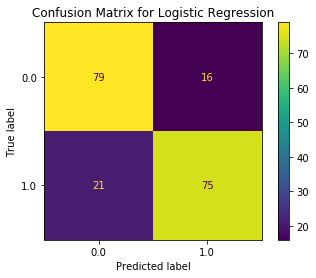

In [46]:
plot_confusion_matrix(clf,x_test,y_test)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

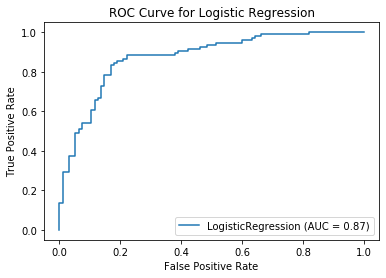

In [47]:
plot_roc_curve(clf,x_test,y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

### Decision Tree

In [48]:
#Optimising model in region about default values
params = {
    'criterion' : ['gini', 'entropy'],   
    'min_samples_split' : [i for i in range(2,5)] 
}
ctr = DecisionTreeClassifier(random_state=387)
gd_sr = GridSearchCV(estimator=ctr,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
ctr = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'criterion': 'gini', 'min_samples_split': 2}


In [49]:
sacc = cross_val_score(ctr, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(ctr.predict(x_test) == y_test)/len(y_test)

print('Decision Tree')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(ctr.predict(x_test), y_test))

Decision Tree
Stratified Accuracy on Training Data: 0.865467032967033
Actual Accuracy on Test Data        : 0.8691099476439791


              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86        86
         1.0       0.92      0.84      0.88       105

    accuracy                           0.87       191
   macro avg       0.87      0.87      0.87       191
weighted avg       0.87      0.87      0.87       191



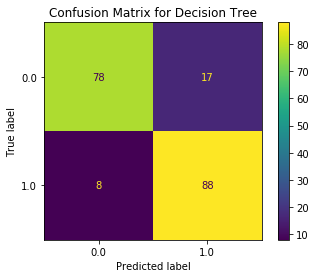

In [50]:
plot_confusion_matrix(ctr,x_test,y_test)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

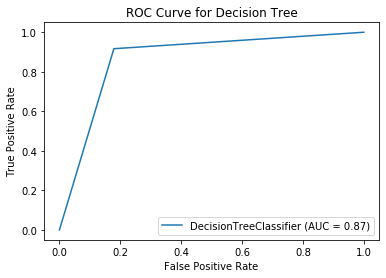

In [51]:
plot_roc_curve(ctr,x_test,y_test)
plt.title('ROC Curve for Decision Tree')
plt.show()

### Neural Network

In [52]:
#Optimising model in region about default values
params = {
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes' : [(90,),(100,),(110,),(90,90),(100,100),(110,110),(90,90,90),(100,100,100),(110,110,110)]
}
cnn = MLPClassifier(random_state=29)
gd_sr = GridSearchCV(estimator=cnn,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
cnn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'hidden_layer_sizes': (90, 90, 90), 'solver': 'adam'}


In [53]:
sacc = cross_val_score(cnn, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(cnn.predict(x_test) == y_test)/len(y_test)

print('Neural Network')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(cnn.predict(x_test), y_test))

Neural Network
Stratified Accuracy on Training Data: 0.8921703296703297
Actual Accuracy on Test Data        : 0.9162303664921466


              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        93
         1.0       0.93      0.91      0.92        98

    accuracy                           0.92       191
   macro avg       0.92      0.92      0.92       191
weighted avg       0.92      0.92      0.92       191



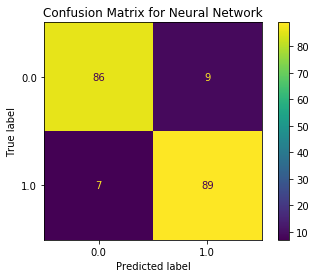

In [54]:
plot_confusion_matrix(cnn,x_test,y_test)
plt.title('Confusion Matrix for Neural Network')
plt.show()

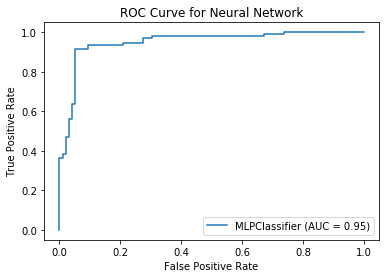

In [55]:
plot_roc_curve(cnn,x_test,y_test)
plt.title('ROC Curve for Neural Network')
plt.show()

### Random Forest

In [56]:
#Optimising model in region about default values
params = {
    'n_estimators' : [i*10 for i in range(7,14)],
    'criterion' : ['gini', 'entropy'],   
    'min_samples_split' : [i for i in range(2,5)] 
}
crf = RandomForestClassifier(random_state=32)
gd_sr = GridSearchCV(estimator=crf,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
crf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 80}


In [57]:
sacc = cross_val_score(crf, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(crf.predict(x_test) == y_test)/len(y_test)

print('Random Forest')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(crf.predict(x_test), y_test))

Random Forest
Stratified Accuracy on Training Data: 0.9074450549450551
Actual Accuracy on Test Data        : 0.9319371727748691


              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93        96
         1.0       0.93      0.94      0.93        95

    accuracy                           0.93       191
   macro avg       0.93      0.93      0.93       191
weighted avg       0.93      0.93      0.93       191



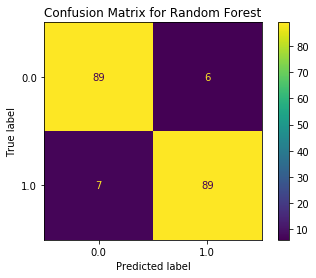

In [58]:
plot_confusion_matrix(crf, x_test, y_test)
plt.title('Confusion Matrix for Random Forest')
plt.show()

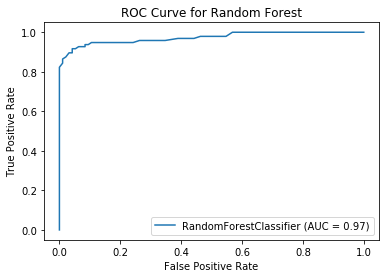

In [59]:
plot_roc_curve(crf,x_test,y_test)
plt.title('ROC Curve for Random Forest')
plt.show()

## Comparison of Model Performance Over Cross Validation

In [68]:
cv = StratifiedKFold(n_splits=10,random_state=857)
accs = {'trial' : [i for i in range(1,11)]}
f1s = {'trial' : [i for i in range(1,11)]}

In [69]:
accs['Random Forest - Accuracy'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
f1s['Random Forest - F1'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Neural Network - Accuracy'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Neural Network - F1'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Decision Tree - Accuracy'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Decision Tree - F1'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Logistic Regression - Accuracy'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Logistic Regression - F1'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['k-Nearest Neighbours - Accuracy'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['k-Nearest Neighbours - F1'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Naive Bayes - Accuracy'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Naive Bayes - F1'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs = pd.DataFrame(accs)
f1s = pd.DataFrame(f1s)

In [70]:
accs

,trial,Random Forest - Accuracy,Neural Network - Accuracy,Decision Tree - Accuracy,Logistic Regression - Accuracy,k-Nearest Neighbours - Accuracy,Naive Bayes - Accuracy
0,1,0.933333,0.885714,0.933333,0.828571,0.857143,0.495238
1,2,0.895238,0.847619,0.838095,0.704762,0.761905,0.523810
2,3,0.866667,0.895238,0.857143,0.790476,0.752381,0.533333
3,4,0.866667,0.857143,0.819048,0.780952,0.733333,0.542857
4,5,0.904762,0.904762,0.866667,0.771429,0.714286,0.523810
5,6,0.942857,0.895238,0.847619,0.800000,0.819048,0.504762
6,7,0.914286,0.914286,0.857143,0.752381,0.771429,0.514286
7,8,0.933333,0.942857,0.895238,0.771429,0.761905,0.504762
8,9,0.923077,0.884615,0.884615,0.759615,0.750000,0.509615
9,10,0.894231,0.894231,0.855769,0.788462,0.778846,0.509615


In [71]:
f1s

,trial,Random Forest - F1,Neural Network - F1,Decision Tree - F1,Logistic Regression - F1,k-Nearest Neighbours - F1,Naive Bayes - F1
0,1,0.935780,0.888889,0.935780,0.833333,0.857143,0.649007
1,2,0.897196,0.857143,0.846847,0.710280,0.770642,0.675325
2,3,0.870370,0.900901,0.862385,0.796296,0.771930,0.679739
3,4,0.862745,0.862385,0.822430,0.772277,0.730769,0.684211
4,5,0.909091,0.910714,0.875000,0.769231,0.727273,0.671053
5,6,0.943396,0.902655,0.854545,0.814159,0.825688,0.666667
6,7,0.917431,0.917431,0.869565,0.750000,0.773585,0.662252
7,8,0.933333,0.943396,0.900901,0.755102,0.747475,0.666667
8,9,0.924528,0.888889,0.888889,0.757282,0.754717,0.670968
9,10,0.900901,0.900901,0.871795,0.796296,0.796460,0.670968


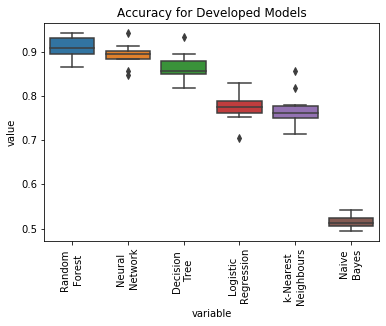

In [95]:
bplot = sb.boxplot(data=accs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('Accuracy for Developed Models')
plt.show()

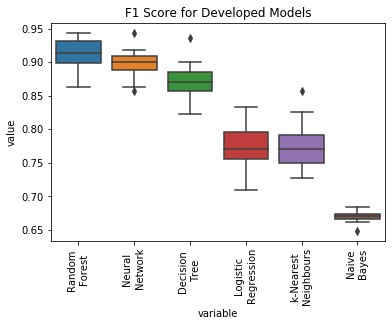

In [96]:
bplot = sb.boxplot(data=f1s.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('F1 Score for Developed Models')
plt.show()

## TODO 
- Add executable to perform analysis automatically